In [1]:
pwd

'/data2/mito_lineage/src/vireo'

In [2]:
INDIR="data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse"
OUTDIR= "data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3"
N_DONORS=4 
#INDIR=""
sample_names="" #"Control,Flt3l,Input"

In [ ]:
from src.utils.data_io import setup_outdir
setup_outdir(OUTDIR, dirs=('figures'))

In [3]:
sample_names = {ind:val for ind,val in enumerate(sample_names.split(","))}


In [4]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

0.4.2


In [5]:
def filt_high(df, thresh):
    return df.loc[(df.mean(axis=1)<thresh)].index.values


# Using vireo for clonal reconstruction - mitochondrial mutations

The mitochondrial mutations data set is extracted from [Ludwig et al, Cell, 2019](https://doi.org/10.1016/j.cell.2019.01.022), the 9 variants used here are from Supp Fig. 2F (and main Fig. 2F).

For clonal reconstruction, we are using the core class `vireoSNP.Vireo` with multiple initializations

## Load cluster results and test for enrichment

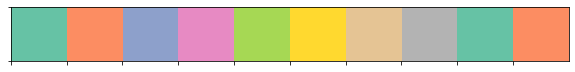

In [6]:
import seaborn as sns
sns.palplot(sns.color_palette('Set2', 10))
from mplh import cluster_help as ch

In [ ]:
n_clone_list = [3, 5, 10, 20, 40]#[2,3,4,5,6,7]

for n in range(N_DONORS):
    curr_ad_f = join(OUTDIR, f"cluster{n}.AD.mtx")
    curr_dp_f = join(OUTDIR, f"cluster{n}.DP.mtx")
    print(curr_ad_f)
    print(curr_dp_f)
    curr_ad = mmread(curr_ad_f).tocsc()
    curr_dp = mmread(curr_dp_f).tocsc()
    curr_labels = pd.read_csv(join(OUTDIR, f"cluster{n}.labels.txt"), index_col=0)
    out_f = join(OUTDIR,"figures", f"cluster{n}_lineage_elbow.png")
    for k in n_clone_list:
        curr_modelCA = pickle.load(open(out_f+f"clones{k}.modelCA.p", "rb"))
        cell_clusters, sample_labels = extract_clusters(curr_modelCA, curr_ad, curr_dp, 
                                                        curr_labels)
        # Create counts df 
        clust_counts = pd.DataFrame(index=["# Control Cells in Cluster", "# Flt3 Cells in Cluster"], 
                                 columns=sample_labels.keys())
        for curr_k in clust_counts.columns:
            clust_counts.at["# Control Cells in Cluster", curr_k] = (sample_labels[curr_k]["sample ID"] == "Control").sum()
            clust_counts.at["# Flt3 Cells in Cluster", curr_k] = (sample_labels[curr_k]["sample ID"] == "Flt3").sum()
        clust_counts = clust_counts.astype(np.double)
        fold_df = pd.DataFrame(np.log2((clust_counts.loc["# Flt3 Cells in Cluster"]+1)/(clust_counts.loc["# Control Cells in Cluster"]+1))).transpose()
        fold_df = fold_df.rename({0:"Flt3 fold enrichment"}, axis=0)                
        
        # Get enrichment
        enrich_df = run_enrichment(clust_counts)
        enrich_stats = pd.concat((clust_counts, fold_df, enrich_df)).transpose()

        f, ax = plt.subplots(nrows=3, ncols=1 ,figsize=(15,15),dpi=300)
        labels = np.array([f"{x:.2E}" for x in enrich_df.astype(float).values[0]])
        #fig, ax = plt.subplots()
        sns.heatmap(enrich_df.astype(float), annot=True, fmt=".2E", cbar=False, #labels.reshape([1, len(labels)]), 
                    cmap='RdYlGn', ax=ax[0])
        
        ax[0].set_title("Flt3 enrichment p-value")

        

        sns.heatmap(fold_df, ax=ax[1],  annot=True, fmt=".2f", cbar=False, cmap="RdBu")
                    #annot=np.array(labels).astype('unicode').reshape([1, len(labels)]))
        ax[1].set_aspect('equal', adjustable='box')
        ax[1].set_title("Log2 Fold change of flt3/control")
        
        plt.xlabel("log2((Flt3+1)/(WT+1))")
        #plt.savefig(out_f+f"clones{k}_labelChange.png")
        #plt.savefig(out_f+f"clones{k}_labelCounts.png")
        sns.heatmap((clust_counts.astype(int)), vmin=0, ax=ax[2],annot=True, fmt=".1E", cbar=False, cmap="Blues")
        ax[2].set_title("Number of cells in each cluster")
        
        plt.suptitle(f"Donor {n}")
        plt.savefig(out_f+f"clones{k}_labelEnrich.png")
        plt.close()

        
        # Put in scatterplot. 
        enrich_stats = pd.concat((clust_counts, fold_df, enrich_df)).transpose()
        enrich_stats['p'] = enrich_stats['p'].astype(np.float32)
        enrich_stats['-log10p'] = -np.log10(enrich_stats['p'])
        enrich_stats.loc[enrich_stats["-log10p"]==np.infty, "-log10p"] = 0
        f = plt.figure(figsize=(10,10))
        sns.scatterplot(data=enrich_stats,x="# Control Cells in Cluster", y="# Flt3 Cells in Cluster", size="-log10p", s=100, 
                        sizes=(20,200), hue="Flt3 fold enrichment", palette="RdBu")
        plt.savefig(out_f+f"clones{k}_scatterEnrich.png")
        plt.close()
        
        
        enrich_stats['Fisher p'] = enrich_stats['Fisher p'].astype(np.float32)
        enrich_stats['Fisher -log10p'] = -np.log10(enrich_stats['Fisher p'])
        enrich_stats.loc[enrich_stats["Fisher -log10p"]==np.infty, "Fisher -log10p"] = 0
        f, ax = plt.subplots(figsize=(10,10))
        sns.scatterplot(data=enrich_stats,x="# Control Cells in Cluster", y="# Flt3 Cells in Cluster", size="Fisher -log10p", s=100, 
                        sizes=(20,200), hue="Flt3 fold enrichment", palette="RdBu")
        plt.axis('square')
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black')
        #ax.plot([0, max(max(enrich_stats[["Control", "Flt3"]]))])

        #helper_save(out_f+f"clones{k}_scatterFisherEnrich.png", to_pdf=False)
        plt.savefig(out_f+f"clones{k}_scatterFisherEnrich.png", dpi=300)
        plt.close()